# BetaVAE on CARS196 dataset

The <a href="https://www.tensorflow.org/datasets/catalog/cars196">cars196</a> dataset contains 16,185 images of 196 different types of cars, which
can be used to train a supervised learning system to determine the make and model of a vehicle in a photograph.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

/opt/anaconda3/envs/NN/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's get the data. Working on your machine, change `download` to `True` and change `DATA_DIR` to the name of the local directory you want to download the data to.

In [2]:
DATA_DIR = './cars196'

[train_ds, test_ds], ds_info = tfds.load(
    "cars196",
    # Reserve 10% for validation and 50% for test
    split=["train", "test"],
    as_supervised=True,  # Include labels
    with_info=True,
    download=True,
    data_dir=DATA_DIR,
)

Now, let's use the built-in visualization function to show some example images:

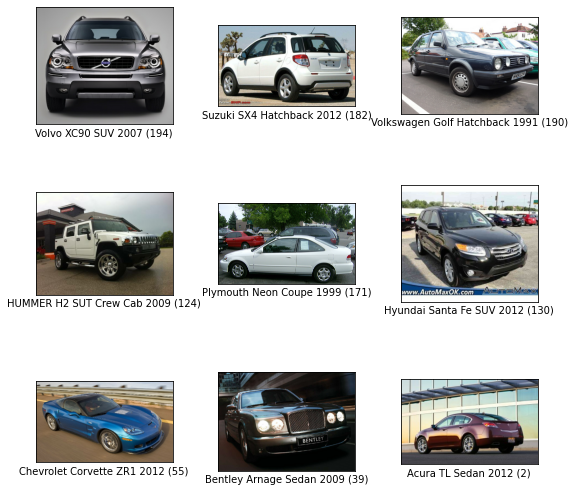

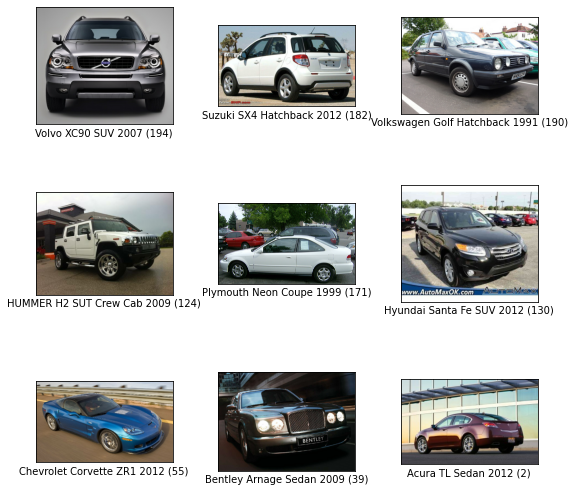

In [3]:
tfds.visualization.show_examples(train_ds, ds_info)

In [4]:
train_ds

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

## Resize images

In [6]:
height, width = 400, 600

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (height, width))))
#validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, (height, width))))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, (height, width))))
train_ds

<MapDataset shapes: (400, 600, 3), types: tf.float32>

## Random data augmentation

Let's the data and use caching and prefetching to optimize load speed:

In [7]:
batch_size = 32

def augment_func(image):
    image = tf.image.resize_with_crop_or_pad(image,height+10,width+10)
    #image = tf.clip_by_value(image,0,255) #make sure you have no color value higher than 225 or lower than 0.
    image = tf.image.random_crop(image,size=[height,width,3])
    image = tf.image.random_flip_left_right(image) #different aspect of vehicles
    image = tf.image.random_hue(image,0.2) #random color, change a red cat into a blue car
    image = tf.image.random_contrast(image,0.5,2)# random contrast
    image = tf.image.random_saturation(image,0,2)# random sturations
    return image

# cache makes the images ready before running
train_ds = train_ds.cache().map(augment_func).shuffle(100).batch(batch_size).prefetch(buffer_size=10) 
test_ds = test_ds.cache().map(augment_func).batch(batch_size).prefetch(buffer_size=10)

## Normalize images
Pixel values from range (0,255) to range (0,1)

In [9]:
train_ds = train_ds.map(lambda x: x / 255.)
#validation_ds = validation_ds.map(lambda x: x / 255.)
test_ds = test_ds.map(lambda x: x / 255.)
train_ds

<MapDataset shapes: (None, 400, 600, 3), types: tf.float32>

Let's visualize what the first 18 images of the first batch looks like after various random transformations.

Note that because the augmentations in the previous cell are applied randomly, these images will look different everytime they are run through the model during training.

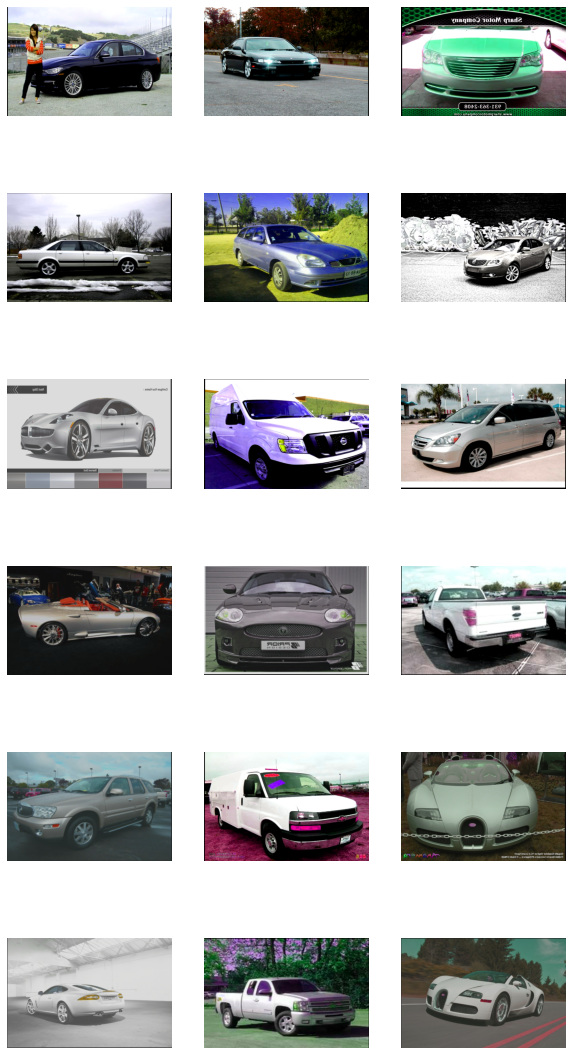

In [10]:
plt.figure(figsize=(10, 20))
for i, image_batch in enumerate(train_ds.take(18)): # we did batch(batch_size) before, if we didn't, "take" will take individual image.
        ax = plt.subplot(6, 3, i + 1)
        plt.imshow(image_batch[3].numpy()) #tensor flow treats things as floating numbers, but images need integer.
        #plt.title(ds_info.features["label"].names[int(label[3])])
        plt.axis("off")


In [11]:
train_ds

<MapDataset shapes: (None, 400, 600, 3), types: tf.float32>

## Build a model

In [13]:
import model
from model import *

In [14]:
filters = [32,64]
latent_dim = 10
image_size = (400,600,3)

In [15]:
encoder10 = Encoder(filters=filters,latent_dim=latent_dim,image_shape=image_size)
encoder10.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 400, 600, 3) 0                                            
__________________________________________________________________________________________________
conv_layer_1 (Conv2D)           (None, 200, 300, 32) 896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv_norm_1 (BatchNormalization (None, 200, 300, 32) 128         conv_layer_1[0][0]               
__________________________________________________________________________________________________
conv_relu_1 (ReLU)              (None, 200, 300, 32) 0           conv_norm_1[0][0]                
____________________________________________________________________________________________

In [16]:
decoder10 = Decoder(latent_dim=latent_dim,filters=filters,last_convdims=(100, 150), img_depth=3)
decoder10.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_input (InputLayer)    [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 960000)            10560000  
_________________________________________________________________
reshape (Reshape)            (None, 100, 150, 64)      0         
_________________________________________________________________
deconv2d_1 (Conv2DTranspose) (None, 200, 300, 64)      36928     
_________________________________________________________________
deconv_norm_1 (BatchNormaliz (None, 200, 300, 64)      256       
_________________________________________________________________
deconv_relu_1 (ReLU)         (None, 200, 300, 64)      0         
_________________________________________________________________
deconv2d_2 (Conv2DTranspose) (None, 400, 600, 64)      3692

In [17]:
vae10 = VAE(encoder10,decoder10,beta=2.)
vae10.compile(optimizer=keras.optimizers.Adam())
vae10.fit(train_ds, epochs=10, batch_size=64)

Epoch 1/10
255/255 [==============================] - 10642s 42s/step - Total_loss: 265381.3125 - Reconstruction_loss: 163194.3750 - KL_loss: 51093.5156
Epoch 2/10
144/255 [===============>..............] - ETA: 6:09:38 - Total_loss: 161947.5938 - Reconstruction_loss: 161947.5312 - KL_loss: 0.0312

Save the model for later use.

In [ ]:
vae10.save("VAE10.h5", save_format="h5")